# Continuous actions with MLP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

You can skip training and instead load the last trained policy by changing the flag below.

In [3]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

## MASAC

In [4]:
from navground.learning import DefaultObservationConfig, DefaultStateConfig
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker, PadReward
from navground.learning.scenarios.pad import render_kwargs

name = "DistributedCommFloatWithRewardSharing"
comm_size = 1
kwargs = render_kwargs(comm=True, low=-1, high=1, 
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
action = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                     fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
state = DefaultStateConfig(include_y=False, include_position=True, include_velocity=True)
sensors = [comm(size=comm_size, binarize=False), marker()]
train_env = get_env(action=action, observation=observation, state=state,
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0.5), include_success=False)
test_env = get_env(action=action, observation=observation, sensors=sensors, state=state,
                   start_in_opposite_sides=True, 
                   include_success=True, init_success=False, intermediate_success=True, 
                   render_mode='rgb_array', render_kwargs=kwargs)

In [5]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [6]:
%%run_if $training

import os
from benchmarl.algorithms import MasacConfig
from benchmarl.models.mlp import MlpConfig
from benchmarl.experiment import ExperimentConfig
from navground.learning.utils.benchmarl import NavgroundExperiment, ExportPolicyCallback

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac.folder_name

PosixPath('logs/DistributedCommFloatWithRewardSharing/MASAC/masac_navground_mlp__1e615e81_25_05_21-15_59_07')

In [7]:
%%run_if $training

experiment_masac.run_for(iterations=20)

mean return = -50.01181411743164: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:26<00:00, 22.34s/it]


We can evalute the policy directly using

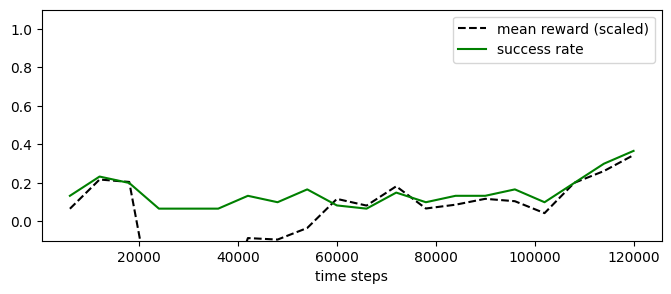

In [8]:
experiment_masac.plot_eval_logs(reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3))

In [10]:
from stable_baselines3.common.evaluation import evaluate_policy
from navground.learning.parallel_env import make_vec_from_penv

test_venv = make_vec_from_penv(test_env)
policy_masac = experiment_masac.load_policy(name='best_policy')
evaluate_policy(policy_masac, test_venv, n_eval_episodes=30)

(-163.7968806942304, 78.07210597448923)

In [11]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=policy_masac, factor=4, select=2, of=31, **kwargs)

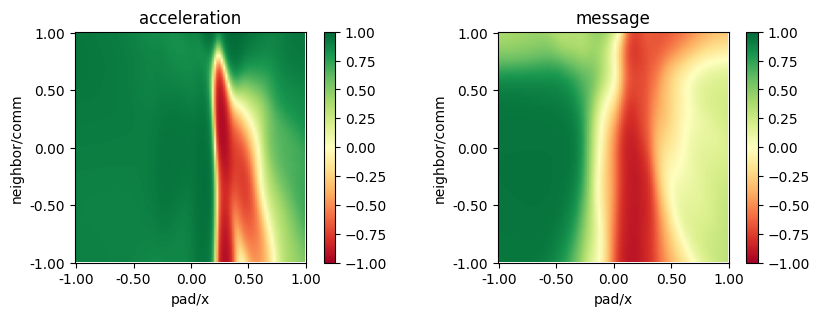

In [14]:
from navground.learning.utils.plot import plot_policy

plot_policy(policy_masac, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

## MAPPO

In [16]:
train_env_mappo = get_env(action=action, observation=observation, state=state,
                          sensors=sensors, start_in_opposite_sides=True, 
                          reward=PadReward(neighbor_weight=0.5), include_success=False)

In [17]:
%%skip_if $training

path = max(pathlib.Path(f'logs/{name}/MAPPO').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [19]:
%%run_if $training

from benchmarl.algorithms import MappoConfig

algorithm = MappoConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MAPPO'
config.max_n_iters = 1
os.makedirs(config.save_folder, exist_ok=True)
experiment_mappo = NavgroundExperiment(
    env=train_env_mappo,
    eval_env=test_env,
    config=config,
    model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_mappo.folder_name

PosixPath('logs/DistributedCommFloatWithRewardSharing/MAPPO/mappo_navground_mlp__21107964_25_05_21-16_09_02')

In [20]:
%%run_if $training

experiment_mappo.run_for(iterations=20)

mean return = -104.82219696044922: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:14<00:00, 21.74s/it]


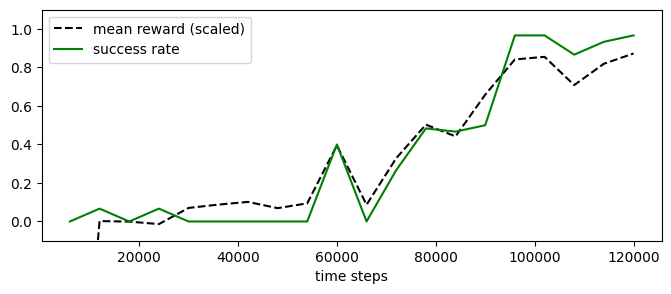

In [21]:
experiment_mappo.plot_eval_logs(reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3))

In [22]:
policy_mappo = experiment_mappo.load_policy(name='best_policy')
evaluate_policy(policy_mappo, test_venv, n_eval_episodes=30)

(-14.98083089987437, 16.28543382920021)

In [23]:
display_episode_video(test_env, policy=policy_mappo, factor=4, select=2, of=31, **kwargs)

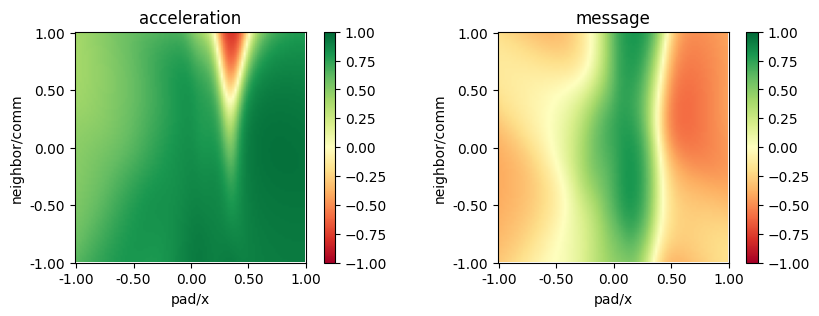

In [24]:
plot_policy(policy_mappo, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)